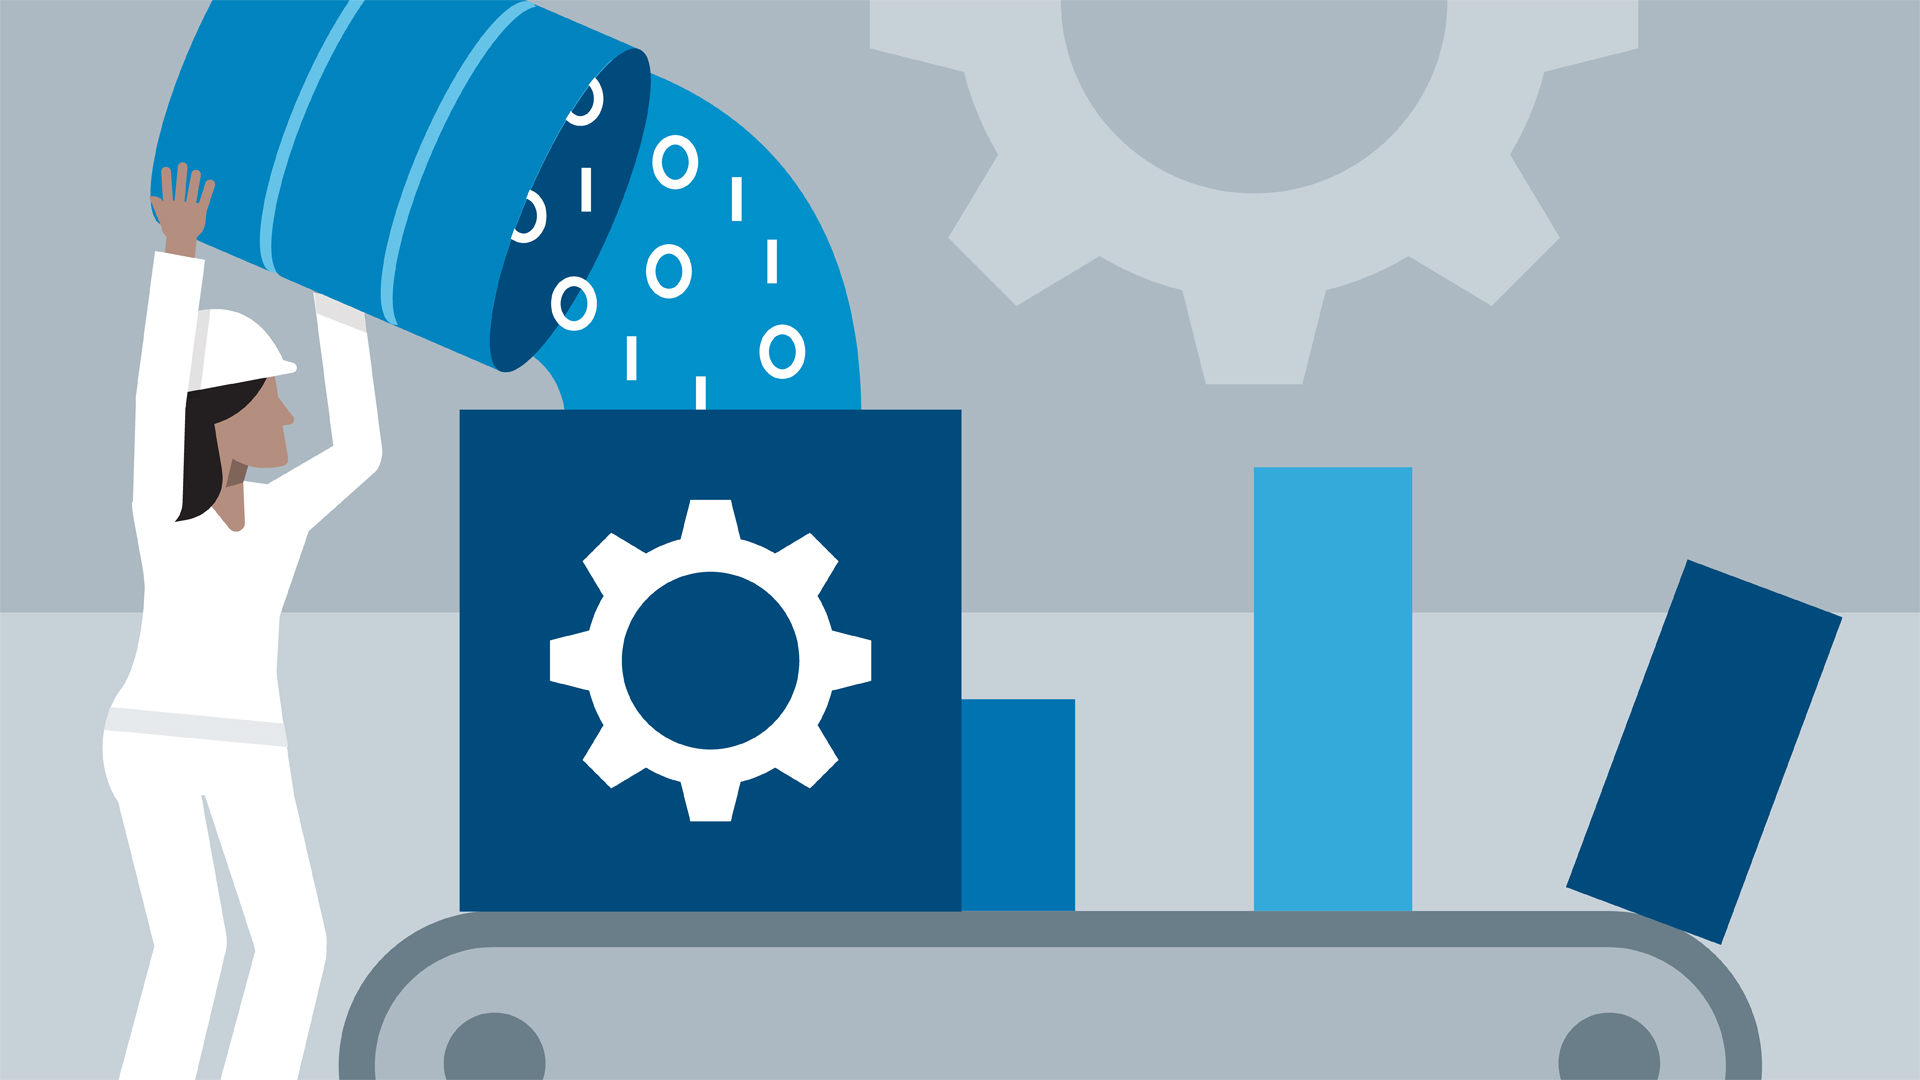

<center>

## In your hands - A Data Engineering Project
___

<center>

##### Pablo de la Asunción Cumbrera Conde

### Índice

- Introducción
- Librerias
- Contrucción y limpieza del Set de Datos 1 (VOC 2012)
- Construcción y limpieza del Set de Datos 2
- Anexión de Data Frames
- Definición de un pipeline de datos (flow) como alternativa
- Conclusión

#### Introducción
___

#### Objetivo y tareas

- Objetivo

Construcción de un Set de Datos a partir de otros dos, al que se le añade una categoría extra (20+1)

- Tareas

    - Extracción de los datos
    - Exploración y comprensión de los datos
    - Limpieza de los datos
    - Compatibilización de los datos
    - Construcción del nuevo Set de Datos
    - Definir la posibilidad de un flujo de datos

#### Presentación de los Set de Datos

- Primer Set de Datos

El Visual Object Classes Challenge 2012 (VOC2012) es un projecto de Redes Neuronales Convolucionales con 20 clases de objetos en los que se realizan diferentes tareas. Aplicaremos Transfer Learning con este Set de Datos junto con el Siguiente.

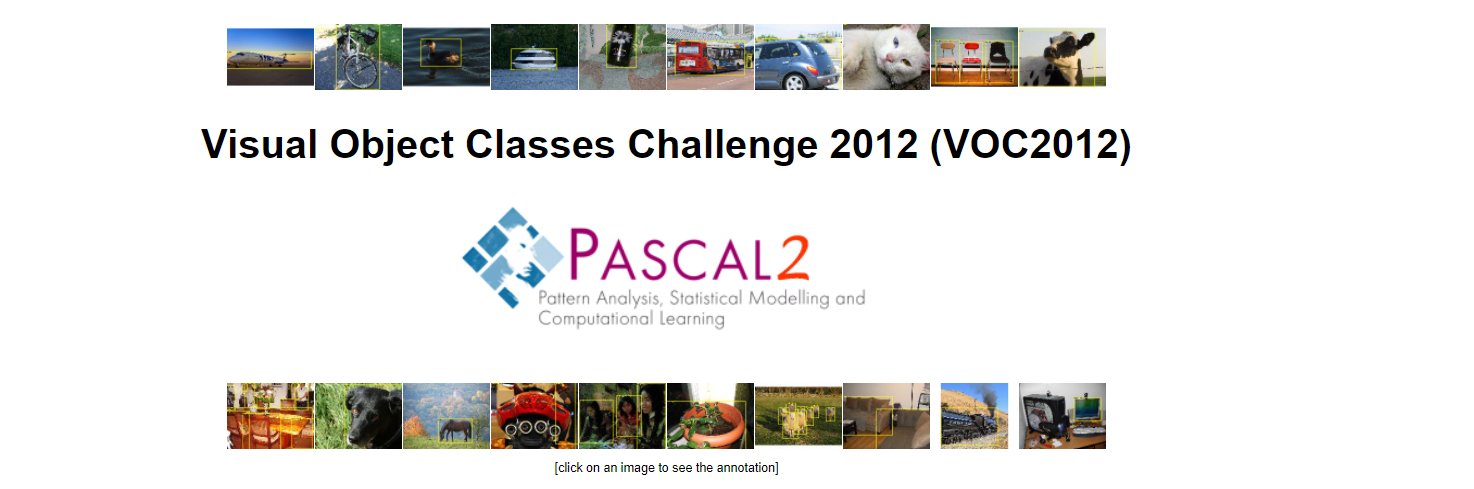

1. Link Home Page: http://host.robots.ox.ac.uk/pascal/VOC/
2. Citation : @misc{pascal-voc-2009,
	author = "Everingham, M. and Van~Gool, L. and Williams, C. K. I. and Winn, J. and Zisserman, A.",
	title = "The {PASCAL} {V}isual {O}bject {C}lasses {C}hallenge 2009 {(VOC2009)} {R}esults",
	howpublished = "http://www.pascal-network.org/challenges/VOC/voc2009/workshop/index.html"}	

- Segundo Set de Datos

El segundo set de datos comprende la categoría "manos" que deberemos añadir al set de datos anterior.

El set de datos llamado "Hand Data Set" tiene como autores a Arpit Mittal, Andrew Zisserman y Phil Torr. Consiste en 13050 manos (1500x1500 píxeles) con el rectángulo de localización orientado a su muñeca.

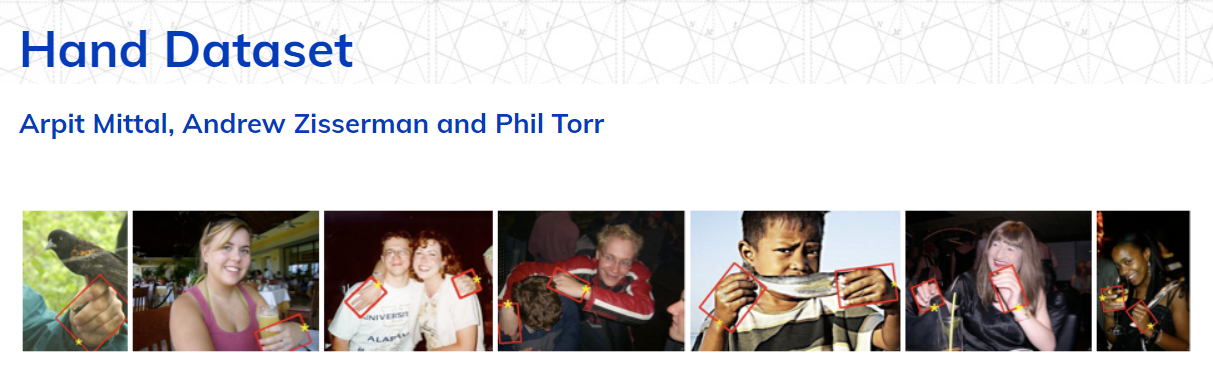

 1. Link al paper: https://www.robots.ox.ac.uk/~vgg/publications-new/Public/2011/Mittal11/
 2. Acknowledgements: This work is funded by the ERC grant VisRec no. 228180 and ONR MURI N00014-07-1-0182.

#### Librerias 
___

In [41]:
import os, sys
from os.path import dirname, join as pjoin
import numpy as np
import scipy.io as sio
import xml.etree.ElementTree as ET
import pandas as pd
from sklearn import preprocessing
import matplotlib.pyplot as plt
import tensorflow as tf

import scipy.io as sio
from os import listdir
from os.path import isfile, join
import math 
import cv2
from xml.dom import minidom


#### Contrucción y limpieza del Set de Datos 1 (VOC 2012)
___

Para este caso debemos etiquetar las fotos con su correspondiente XML y limpiar los datos

In [2]:
    BASE_PATH = r"C:\Users\pablo.cumbrera\Documents\Data\Raw DATA\\VOC2012\VOC2012"
    XML_PATH = os.path.join(BASE_PATH, "Annotations")
    IMG_PATH = os.path.join(BASE_PATH, "JPEGImages")
    XML_FILES = [os.path.join(XML_PATH, f) for f in os.listdir(XML_PATH)]

In [3]:
class XmlParser(object):

    def __init__(self,xml_file):

        self.xml_file = xml_file
        self._root = ET.parse(self.xml_file).getroot()
        self._objects = self._root.findall("object")
        # path to the image file as describe in the xml file
        self.img_path = os.path.join(IMG_PATH, self._root.find('filename').text)
        # image id 
        self.image_id = self._root.find("filename").text
        # names of the classes contained in the xml file
        self.names = self._get_names()
        # coordinates of the bounding boxes
        self.boxes = self._get_bndbox()

    def parse_xml(self):
        """"Parse the xml file returning the root."""
    
        tree = ET.parse(self.xml_file)
        return tree.getroot()

    def _get_names(self):

        names = []
        for obj in self._objects:
            name = obj.find("name")
            names.append(name.text)

        return np.array(names)

    def _get_bndbox(self):

        boxes = []
        for obj in self._objects:
            coordinates = []
            bndbox = obj.find("bndbox")
            coordinates.append(np.int32(bndbox.find("xmin").text))
            coordinates.append(np.int32(np.float32(bndbox.find("ymin").text)))
            coordinates.append(np.int32(bndbox.find("xmax").text))
            coordinates.append(np.int32(bndbox.find("ymax").text))
            boxes.append(coordinates)

        return np.array(boxes)

- Hacemos un Data Frame con los Datos obtenidos

In [4]:
def xml_files_to_df(xml_files):
    
    """"Return pandas dataframe from list of XML files."""
    
    names = []
    boxes = []
    image_id = []
    xml_path = []
    img_path = []
    for file in xml_files:
        xml = XmlParser(file)
        names.extend(xml.names)
        boxes.extend(xml.boxes)
        image_id.extend([xml.image_id] * len(xml.names))
        xml_path.extend([xml.xml_file] * len(xml.names))
        img_path.extend([xml.img_path] * len(xml.names))
    a = {"image_id": image_id,
         "names": names,
         "boxes": boxes,
         "xml_path":xml_path,
         "img_path":img_path}
    
    df = pd.DataFrame.from_dict(a, orient='index')
    df = df.transpose()
    
    return df

In [5]:
voc_data = xml_files_to_df(XML_FILES)
voc_data.head()

,image_id,names,boxes,xml_path,img_path
0,2007_000027.jpg,person,"[174, 101, 349, 351]",C:\Users\pablo.cumbrera\Documents\Data\Raw DAT...,C:\Users\pablo.cumbrera\Documents\Data\Raw DAT...
1,2007_000032.jpg,aeroplane,"[104, 78, 375, 183]",C:\Users\pablo.cumbrera\Documents\Data\Raw DAT...,C:\Users\pablo.cumbrera\Documents\Data\Raw DAT...
2,2007_000032.jpg,aeroplane,"[133, 88, 197, 123]",C:\Users\pablo.cumbrera\Documents\Data\Raw DAT...,C:\Users\pablo.cumbrera\Documents\Data\Raw DAT...
3,2007_000032.jpg,person,"[195, 180, 213, 229]",C:\Users\pablo.cumbrera\Documents\Data\Raw DAT...,C:\Users\pablo.cumbrera\Documents\Data\Raw DAT...
4,2007_000032.jpg,person,"[26, 189, 44, 238]",C:\Users\pablo.cumbrera\Documents\Data\Raw DAT...,C:\Users\pablo.cumbrera\Documents\Data\Raw DAT...


In [6]:
#Valores para cada clase
voc_data['names'].value_counts()

person         17401
chair           3056
car             2492
dog             1598
bottle          1561
cat             1277
bird            1271
pottedplant     1202
sheep           1084
boat            1059
aeroplane       1002
tvmonitor        893
sofa             841
bicycle          837
horse            803
motorbike        801
diningtable      800
cow              771
train            704
bus              685
Name: names, dtype: int64

In [7]:
# eliminamos la extensión .jpg de "image_id"
voc_data['img_id'] = voc_data['image_id'].apply(lambda x:x.split('.')).map(lambda x:x[0])
voc_data.drop(columns=['image_id'], inplace=True)
voc_data.head()

,names,boxes,xml_path,img_path,img_id
0,person,"[174, 101, 349, 351]",C:\Users\pablo.cumbrera\Documents\Data\Raw DAT...,C:\Users\pablo.cumbrera\Documents\Data\Raw DAT...,2007_000027
1,aeroplane,"[104, 78, 375, 183]",C:\Users\pablo.cumbrera\Documents\Data\Raw DAT...,C:\Users\pablo.cumbrera\Documents\Data\Raw DAT...,2007_000032
2,aeroplane,"[133, 88, 197, 123]",C:\Users\pablo.cumbrera\Documents\Data\Raw DAT...,C:\Users\pablo.cumbrera\Documents\Data\Raw DAT...,2007_000032
3,person,"[195, 180, 213, 229]",C:\Users\pablo.cumbrera\Documents\Data\Raw DAT...,C:\Users\pablo.cumbrera\Documents\Data\Raw DAT...,2007_000032
4,person,"[26, 189, 44, 238]",C:\Users\pablo.cumbrera\Documents\Data\Raw DAT...,C:\Users\pablo.cumbrera\Documents\Data\Raw DAT...,2007_000032


In [8]:
# Necesitamos hacer Label Encoder para el task
enc = preprocessing.LabelEncoder()
voc_data['labels'] = enc.fit_transform(voc_data['names'])
voc_data['labels'] = np.stack(voc_data['labels'][i]+1 for i in range(len(voc_data['labels']))) 

C:\Users\pablo.cumbrera\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3338: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


In [9]:
classes = voc_data[['names','labels']].value_counts(ascending=False)
classes

names        labels
person       15        17401
chair        9          3056
car          7          2492
dog          12         1598
bottle       5          1561
cat          8          1277
bird         3          1271
pottedplant  16         1202
sheep        17         1084
boat         4          1059
aeroplane    1          1002
tvmonitor    20          893
sofa         18          841
bicycle      2           837
horse        13          803
motorbike    14          801
diningtable  11          800
cow          10          771
train        19          704
bus          6           685
dtype: int64

In [10]:
# Hacemos un diccionario para cada clase de objeto para que podamos llamar a los objetos por un key
classes= {1:'aeroplane',2:'bicycle',3:'bird',4:'boat',5:'bottle',6:'bus',7:'car',8:'cat',9:'chair',10:'cow',
          11:'diningtable',12:'dog',13:'horse',14:'motorbike',
          15:'person',16:'pottedplant',17:'sheep',18:'sofa',19:'train',20:'tvmonitor'}

In [11]:
# Coordenadas de las cajas tienen que ir en columnas separadas

voc_data['xmin'] = -1
voc_data['ymin'] = -1
voc_data['xmax'] = -1
voc_data['ymax'] = -1

voc_data[['xmin','ymin','xmax','ymax']]=np.stack(voc_data['boxes'][i] for i in range(len(voc_data['boxes'])))

voc_data.drop(columns=['boxes'], inplace=True)
voc_data['xmin'] = voc_data['xmin'].astype(np.float)
voc_data['ymin'] = voc_data['ymin'].astype(np.float)
voc_data['xmax'] = voc_data['xmax'].astype(np.float)
voc_data['ymax'] = voc_data['ymax'].astype(np.float)

In [12]:
# Borramos los numeros de las columnas porque ya no los necesitamos
voc_data.drop(columns=['names'], inplace=True)
voc_data.head()

,xml_path,img_path,img_id,labels,xmin,ymin,xmax,ymax
0,C:\Users\pablo.cumbrera\Documents\Data\Raw DAT...,C:\Users\pablo.cumbrera\Documents\Data\Raw DAT...,2007_000027,15,174.0,101.0,349.0,351.0
1,C:\Users\pablo.cumbrera\Documents\Data\Raw DAT...,C:\Users\pablo.cumbrera\Documents\Data\Raw DAT...,2007_000032,1,104.0,78.0,375.0,183.0
2,C:\Users\pablo.cumbrera\Documents\Data\Raw DAT...,C:\Users\pablo.cumbrera\Documents\Data\Raw DAT...,2007_000032,1,133.0,88.0,197.0,123.0
3,C:\Users\pablo.cumbrera\Documents\Data\Raw DAT...,C:\Users\pablo.cumbrera\Documents\Data\Raw DAT...,2007_000032,15,195.0,180.0,213.0,229.0
4,C:\Users\pablo.cumbrera\Documents\Data\Raw DAT...,C:\Users\pablo.cumbrera\Documents\Data\Raw DAT...,2007_000032,15,26.0,189.0,44.0,238.0


In [13]:
len(voc_data['img_id'].unique())

17125

#### Contrucción y limpieza del Set de Datos 2 (Hand Dataset)
___

Para este caso debemos etiquetar las fotos con su correspondiente, no obstante, hay que cambiar el formato de .MAT a XML. Hay que limpiar los datos y comprobar que la forma en que se dan los datos de la coordenada del bounding box son iguales que en el caso anterior.

In [14]:
#Creamos caminos a cada tipo de archivos

BASE_2_PATH = r'C:\Users\pablo.cumbrera\Documents\Data\Raw DATA\HandsRobot\hand_dataset'


TRAIN_MAT = os.path.join(BASE_2_PATH, r"training_dataset\training_data\annotations")
TEST_MAT = os.path.join(BASE_2_PATH, r"test_dataset\test_data\annotations")
VAL_MAT = os.path.join(BASE_2_PATH, r"validation_dataset\validation_data\annotations")
TRAIN_IMG_PATH = os.path.join(BASE_2_PATH, r"training_dataset\training_data\images")
TEST_IMG_PATH = os.path.join(BASE_2_PATH, r"test_dataset\test_data\images")
VAL_IMG_PATH = os.path.join(BASE_2_PATH, r"validation_dataset\validation_data\images")


MAT_TRAINING_FILES = [os.path.join(TRAIN_MAT, f) for f in os.listdir(TRAIN_MAT)]
MAT_TEST_FILES = [os.path.join(TEST_MAT, f) for f in os.listdir(TEST_MAT)]
MAT_VALIDATION_FILES = [os.path.join(VAL_MAT, f) for f in os.listdir(VAL_MAT)]

- Tratamos la compatibilidad del formato de los datos

In [15]:
BASE_2_PATH = r'C:\Users\pablo.cumbrera\Documents\Data\Raw DATA\HandsRobot\hand_dataset'
MAT_FILES_PATH= os.path.join(BASE_2_PATH, r"training_dataset\training_data\annotations")
IMG_FILES_PATH= os.path.join(BASE_2_PATH, r"training_dataset\training_data\images")
XML_FILES_PATH= os.path.join(BASE_2_PATH, r"training_dataset\training_data\annotations_xml")


def get_img_size_node(img_path):
    img = cv2.imread(img_path)
    img_size = img.shape
    size_node = ET.Element('size')
    
    width_node = ET.Element('width')
    width_node.text = str(img_size[0])
    size_node.append(width_node)
    
    height_node = ET.Element('height')
    height_node.text = str(img_size[1])
    size_node.append(height_node)

    depth_node = ET.Element('depth')
    depth_node.text = str(img_size[2])
    size_node.append(depth_node)

    return size_node


def get_object_node(hand):
    
    hand_node = ET.Element('object')

    name_node = ET.Element('name')
    name_node.text = 'hand'
    hand_node.append(name_node)
    
    pose_node = ET.Element('pose')
    pose_node.text = 'Unspecified'
    hand_node.append(pose_node)

    truncated_node = ET.Element('truncated')
    truncated_node.text = '0'
    hand_node.append(truncated_node)

    difficult_node = ET.Element('difficult')
    difficult_node.text = '0'
    hand_node.append(difficult_node)

    bbox_node = ET.Element('bndbox')
    xmin_node = ET.Element('xmin')
    xmin_node.text = '{0:.2f}'.format(hand[0])
    bbox_node.append(xmin_node)

    ymin_node = ET.Element('ymin')
    ymin_node.text = '{0:.2f}'.format(hand[1])
    bbox_node.append(ymin_node)

    xmax_node = ET.Element('xmax')
    xmax_node.text = '{0:.2f}'.format(hand[2])
    bbox_node.append(xmax_node)
    
    ymax_node = ET.Element('ymax')
    ymax_node.text = '{0:.2f}'.format(hand[3])
    bbox_node.append(ymax_node)

    hand_node.append(bbox_node)

    return hand_node

#Read the given mat file and add hand objects to the corresponding XML file
def read_mat_file(filepath, filename):

    mat_data = sio.loadmat(filepath)
    hand_pos = [] # To store the hand positions in an image

    #For all hands in the image align the bounding box to an axis
    for i in range(len(mat_data['boxes'][0])):
        xmin = math.inf  
        ymin = math.inf 
        xmax = -1
        ymax = -1

        for j in range(4):
            x, y = mat_data['boxes'][0][i][0][0][j][0]
            if xmin > x:
                xmin = x
            if ymin > y:
                ymin = y
            if xmax < x:
                xmax = x
            if ymax < y:
                ymax = y

        hand_pos.insert(0, [xmin, ymin, xmax, ymax])
    
    # Create the XML file
    create_xml_file(hand_pos, filename)

In [16]:
def create_xml_file(hand_pos, filename):
        
    #Generate the image file name
    img_filename = filename.split('.')[0] + '.jpg'
    xml_filename = filename.split('.')[0] + '.xml'

    root = ET.Element('annotation')
    tree = ET.ElementTree(root) # Create a XML tree with root as 'annotation'

    #Create an element folder
    folder = ET.Element('folder')
    folder.text = 'imgs/'
    root.append(folder)

    #Add filename
    filename_node = ET.Element('filename')
    filename_node.text = img_filename
    root.append(filename_node)

    #Add filepath
    filepath_node = ET.Element('path')
    filepath_node.text = filename_node.text
    root.append(filepath_node)

    # Node for the size of the image
    img_path = join(IMG_FILES_PATH, img_filename)
    size_node = get_img_size_node(img_path)
    root.append(size_node)

    #Add segmented node
    segmented_node = ET.Element('segmented')
    segmented_node.text = '0'
    root.append(segmented_node)

    #Add the objects
    for hand in hand_pos:
        hand_node = get_object_node(hand)
        root.append(hand_node)
    
    rough_xml = ET.tostring(root, 'utf-8')
    rough_xml = minidom.parseString(rough_xml)
    pretty_xml = rough_xml.toprettyxml()
    #print(pretty_xml)

    # Save the XML file 
    xml_path = join(XML_FILES_PATH, xml_filename)
    with open(xml_path, 'w') as xml_file:
        xml_file.write(pretty_xml)

def main():
    # Read a .mat file and convert it to a pascal format
    # List all files in the MAT_FILES_PATH and ignore hidden files (.DS_STORE for Macs)
    mat_files = [[join(MAT_FILES_PATH, x), x] for x in listdir(MAT_FILES_PATH) if isfile(join(MAT_FILES_PATH, x)) and x[0] is not '.']
    # Iterate through all files and convert them to XML
    for mat_file in mat_files:
        #print(mat_file)
        read_mat_file(mat_file[0], mat_file[1])
        #break

if __name__ == '__main__':
    main()

<>:53: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:53: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<ipython-input-16-07a993f89d65>:53: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  mat_files = [[join(MAT_FILES_PATH, x), x] for x in listdir(MAT_FILES_PATH) if isfile(join(MAT_FILES_PATH, x)) and x[0] is not '.']


- Pasamos los datos a Data Frame. En este caso no es necesario pasar los datos a int() por lo que hay que retocar la función de "_get_bndbox" dentro de "XmlParser".

In [17]:
class XmlParser(object):

    def __init__(self,xml_file):

        self.xml_file = xml_file
        self._root = ET.parse(self.xml_file).getroot()
        self._objects = self._root.findall("object")
        # path to the image file as describe in the xml file
        self.img_path = os.path.join(IMG_FILES_PATH, self._root.find('filename').text)
        # image id 
        self.image_id = self._root.find("filename").text
        # names of the classes contained in the xml file
        self.names = self._get_names()
        # coordinates of the bounding boxes
        self.boxes = self._get_bndbox()

    def parse_xml(self):
        """"Parse the xml file returning the root."""
    
        tree = ET.parse(self.xml_file)
        return tree.getroot()

    def _get_names(self):

        names = []
        for obj in self._objects:
            name = obj.find("name")
            names.append(name.text)

        return np.array(names)

    def _get_bndbox(self):

        boxes = []
        for obj in self._objects:
            coordinates = []
            bndbox = obj.find("bndbox")
            coordinates.append(bndbox.find("xmin").text)
            coordinates.append(np.float32(bndbox.find("ymin").text))
            coordinates.append(bndbox.find("xmax").text)
            coordinates.append(bndbox.find("ymax").text)
            boxes.append(coordinates)

        return np.array(boxes)

In [18]:
XML_FILES_PATH= os.path.join(BASE_2_PATH, r"training_dataset\training_data\annotations_xml")
XML_FILES_2 = [os.path.join(XML_FILES_PATH, f) for f in os.listdir(XML_FILES_PATH)]

hand_data = xml_files_to_df(XML_FILES_2)
hand_data.head()

,image_id,names,boxes,xml_path,img_path
0,Buffy_1.jpg,hand,"[449.81, 384.24, 493.19, 426.76]",C:\Users\pablo.cumbrera\Documents\Data\Raw DAT...,C:\Users\pablo.cumbrera\Documents\Data\Raw DAT...
1,Buffy_1.jpg,hand,"[461.57, 345.62, 492.43, 387.38]",C:\Users\pablo.cumbrera\Documents\Data\Raw DAT...,C:\Users\pablo.cumbrera\Documents\Data\Raw DAT...
2,Buffy_10.jpg,hand,"[369.83, 227.56, 419.17, 282.44]",C:\Users\pablo.cumbrera\Documents\Data\Raw DAT...,C:\Users\pablo.cumbrera\Documents\Data\Raw DAT...
3,Buffy_10.jpg,hand,"[371.45, 131.45, 410.55, 170.55]",C:\Users\pablo.cumbrera\Documents\Data\Raw DAT...,C:\Users\pablo.cumbrera\Documents\Data\Raw DAT...
4,Buffy_100.jpg,hand,"[345.63, 264.36, 396.37, 317.64]",C:\Users\pablo.cumbrera\Documents\Data\Raw DAT...,C:\Users\pablo.cumbrera\Documents\Data\Raw DAT...


In [19]:
# Coordenadas de las cajas tienen que ir en columnas separadas

hand_data['xmin'] = -1
hand_data['ymin'] = -1
hand_data['xmax'] = -1
hand_data['ymax'] = -1

hand_data[['xmin','ymin','xmax','ymax']]=np.stack(hand_data['boxes'][i] for i in range(len(hand_data['boxes'])))

hand_data.drop(columns=['boxes'], inplace=True)
hand_data['xmin'] = hand_data['xmin'].astype(np.float)
hand_data['ymin'] = hand_data['ymin'].astype(np.float)
hand_data['xmax'] = hand_data['xmax'].astype(np.float)
hand_data['ymax'] = hand_data['ymax'].astype(np.float)

C:\Users\pablo.cumbrera\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3338: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


In [20]:
#Valores para cada clase
hand_data['names'].value_counts()

hand    9163
Name: names, dtype: int64

In [21]:
# eliminamos la extensión .jpg de "image_id"
hand_data['img_id'] = hand_data['image_id'].apply(lambda x:x.split('.')).map(lambda x:x[0])
hand_data.drop(columns=['image_id'], inplace=True)
hand_data.head()

,names,xml_path,img_path,xmin,ymin,xmax,ymax,img_id
0,hand,C:\Users\pablo.cumbrera\Documents\Data\Raw DAT...,C:\Users\pablo.cumbrera\Documents\Data\Raw DAT...,449.81,384.24,493.19,426.76,Buffy_1
1,hand,C:\Users\pablo.cumbrera\Documents\Data\Raw DAT...,C:\Users\pablo.cumbrera\Documents\Data\Raw DAT...,461.57,345.62,492.43,387.38,Buffy_1
2,hand,C:\Users\pablo.cumbrera\Documents\Data\Raw DAT...,C:\Users\pablo.cumbrera\Documents\Data\Raw DAT...,369.83,227.56,419.17,282.44,Buffy_10
3,hand,C:\Users\pablo.cumbrera\Documents\Data\Raw DAT...,C:\Users\pablo.cumbrera\Documents\Data\Raw DAT...,371.45,131.45,410.55,170.55,Buffy_10
4,hand,C:\Users\pablo.cumbrera\Documents\Data\Raw DAT...,C:\Users\pablo.cumbrera\Documents\Data\Raw DAT...,345.63,264.36,396.37,317.64,Buffy_100


In [22]:
# Sustituimos cada etiqueta por el valor "21.0", a través de un enconder
enc = preprocessing.LabelEncoder()
hand_data['labels'] = enc.fit_transform(hand_data['names'])
hand_data['labels'] = np.stack(hand_data['labels'][i]+21 for i in range(len(hand_data['labels']))) 
hand_data.drop(['names'], axis=1,inplace=True)
hand_data.head()

C:\Users\pablo.cumbrera\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3338: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


,xml_path,img_path,xmin,ymin,xmax,ymax,img_id,labels
0,C:\Users\pablo.cumbrera\Documents\Data\Raw DAT...,C:\Users\pablo.cumbrera\Documents\Data\Raw DAT...,449.81,384.24,493.19,426.76,Buffy_1,21
1,C:\Users\pablo.cumbrera\Documents\Data\Raw DAT...,C:\Users\pablo.cumbrera\Documents\Data\Raw DAT...,461.57,345.62,492.43,387.38,Buffy_1,21
2,C:\Users\pablo.cumbrera\Documents\Data\Raw DAT...,C:\Users\pablo.cumbrera\Documents\Data\Raw DAT...,369.83,227.56,419.17,282.44,Buffy_10,21
3,C:\Users\pablo.cumbrera\Documents\Data\Raw DAT...,C:\Users\pablo.cumbrera\Documents\Data\Raw DAT...,371.45,131.45,410.55,170.55,Buffy_10,21
4,C:\Users\pablo.cumbrera\Documents\Data\Raw DAT...,C:\Users\pablo.cumbrera\Documents\Data\Raw DAT...,345.63,264.36,396.37,317.64,Buffy_100,21


In [25]:
hand_data.columns = ['xml_path', 'img_path', 'xmin', 'ymin', 'xmax', 'ymax', 'img_id',
       'labels']

In [26]:
len(hand_data['img_id'].unique())

4069

#### Unión de los Data Frames
____

- Unimos los data Frames y los barajamos para utilizarlos como uno solo.

In [29]:
full_dataset = hand_data.append(voc_data)
full_dataset.head(10)

,xml_path,img_path,xmin,ymin,xmax,ymax,img_id,labels
0,C:\Users\pablo.cumbrera\Documents\Data\Raw DAT...,C:\Users\pablo.cumbrera\Documents\Data\Raw DAT...,449.81,384.24,493.19,426.76,Buffy_1,21
1,C:\Users\pablo.cumbrera\Documents\Data\Raw DAT...,C:\Users\pablo.cumbrera\Documents\Data\Raw DAT...,461.57,345.62,492.43,387.38,Buffy_1,21
2,C:\Users\pablo.cumbrera\Documents\Data\Raw DAT...,C:\Users\pablo.cumbrera\Documents\Data\Raw DAT...,369.83,227.56,419.17,282.44,Buffy_10,21
3,C:\Users\pablo.cumbrera\Documents\Data\Raw DAT...,C:\Users\pablo.cumbrera\Documents\Data\Raw DAT...,371.45,131.45,410.55,170.55,Buffy_10,21
4,C:\Users\pablo.cumbrera\Documents\Data\Raw DAT...,C:\Users\pablo.cumbrera\Documents\Data\Raw DAT...,345.63,264.36,396.37,317.64,Buffy_100,21
5,C:\Users\pablo.cumbrera\Documents\Data\Raw DAT...,C:\Users\pablo.cumbrera\Documents\Data\Raw DAT...,381.45,146.45,425.55,190.55,Buffy_100,21
6,C:\Users\pablo.cumbrera\Documents\Data\Raw DAT...,C:\Users\pablo.cumbrera\Documents\Data\Raw DAT...,360.04,231.12,404.96,278.88,Buffy_101,21
7,C:\Users\pablo.cumbrera\Documents\Data\Raw DAT...,C:\Users\pablo.cumbrera\Documents\Data\Raw DAT...,346.80,319.12,394.20,365.88,Buffy_102,21
8,C:\Users\pablo.cumbrera\Documents\Data\Raw DAT...,C:\Users\pablo.cumbrera\Documents\Data\Raw DAT...,379.77,379.19,425.23,425.81,Buffy_103,21
9,C:\Users\pablo.cumbrera\Documents\Data\Raw DAT...,C:\Users\pablo.cumbrera\Documents\Data\Raw DAT...,521.29,373.02,570.71,410.98,Buffy_104,21


In [35]:
classes = full_dataset[['labels']].value_counts(ascending=False)
classes

labels
15        17401
21         9163
9          3056
7          2492
12         1598
5          1561
8          1277
3          1271
16         1202
17         1084
4          1059
1          1002
20          893
18          841
2           837
13          803
14          801
11          800
10          771
19          704
6           685
dtype: int64

In [47]:
len(full_dataset['img_id'].unique())

21194

In [61]:
# Guardamos el Data Frame en nuestra memoria
full_dataset.to_csv('data_voc_hands.csv', header=False, index=False)

#### Definición de un pipeline (flow) de datos como alternativa
___

En nuestras carpetas personales volcamos todos los datos en una misma carpeta (VOC+HANDS) que llamaremos 'directory'

In [78]:
data_dir=r"C:\Users\pablo.cumbrera\Documents\Data\Raw DATA\Directory"

datagen_kwargs = dict(rescale=1./255, validation_split=.20)
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    **datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
    data_dir, subset="validation", shuffle=False)

do_data_augmentation = False
if do_data_augmentation:
    train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2, height_shift_range=0.2,
      shear_range=0.2, zoom_range=0.2,
      **datagen_kwargs)
    
else:
    train_datagen = valid_datagen
train_generator = train_datagen.flow_from_directory(
    data_dir, subset="training", shuffle=True)


Found 4238 images belonging to 3 classes.
Found 16956 images belonging to 3 classes.


- Train Flow

In [79]:
train_generator = train_datagen.flow_from_directory(
    directory=r"C:\Users\pablo.cumbrera\Documents\Data\Raw DATA\Directory\train",
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    shuffle=True,
    seed=42
)

Found 0 images belonging to 0 classes.


- Valid Flow

In [80]:
valid_generator = valid_datagen.flow_from_directory(
    directory=r"C:\Users\pablo.cumbrera\Documents\Data\Raw DATA\Directory\valid",
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    shuffle=True,
    seed=42
)

Found 0 images belonging to 0 classes.


- Test Flow

In [81]:
test_generator = test_datagen.flow_from_directory(
    directory=r"C:\Users\pablo.cumbrera\Documents\Data\Raw DATA\Directory\test",
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=1,
    class_mode=None,
    shuffle=False,
    seed=42
)

Found 0 images belonging to 0 classes.


#### Conclusiones
___

- Hemos desarrollado dos diferentes formas de abordar la creación de un set de datos para realizar diferentes trabajos con insight, o directamente entrenar un modelo.

- Primero probaremos a través del DF pero si el DataSet es demasiado grande, trabajaremos a través de flujos.

#########################################################################################################################
__________________________________________________________________________________________________________